<a href="https://colab.research.google.com/github/zeliasporto/tcc/blob/main/ml_tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Hub Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classificação de texto com BERT

Este trabalho é adaptado de um tutorial que contêm ajustes (fine-tune) para o BERT performar análise de sentimentos em, originalmente, um dataset com texto simples de _reviews_ de filmes no site IMDB. Agora, classifica tweets com temática suicida.

Além de treinar o modelo, também foi incluído como pré-processar o texto em um formato adequado.

Etapas neste notebook:

- Carregar a base de dados do [repositório no Github](https://github.com/zeliasporto/tcc)
- Carregar um modelo BERT do TensorFlow Hub
- Construção do modelo combinando BERT com um classificador
- Treinar o modelo, fazendo o fine-tuning do BERT como parte do processo 

## Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.10.*"

Para poder usar posteriormente o AdamW optimizer do [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install -q tf-models-official==2.10.0

In [ ]:
import numpy as np
import os
import pandas as pd
import random
import shutil
import subprocess

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras import backend as K

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Análise de sentimentos 

Este notebook treina o modelo de análise de sentimetnos para classificar o texto dos tweets em *nocivo*, *protetor* ou genérico*.

Foi usada a [Search API: Premium](https://ai.stanford.edu/~amaas/data/sentiment/) que permite faz requisilçoes que retornem publicações da rede social [Twitter](https://twitter.com) de uma data (fromDate) ate outra (toDate). Após os dados foram classificados e tratados, depois passados para o [repositório no Github](https://github.com/zeliasporto/tcc)

In [ ]:
treinar_2019_testar_2020 = False
so_2019 = True

if treinar_2019_testar_2020:
    num_classes = 3

    url2019 = 'https://github.com/hsandmann/zelia.data/raw/main/tweets_normalizados_2019.xlsx'
    df2019 = pd.read_excel(url2019)
    df2019 = df2019.drop(['id'], axis=1)
    df2019 = df2019.sample(frac = 1)
    df2019["classe"] = tf.keras.utils.to_categorical(df2019["classe"].to_numpy() - 1, num_classes=num_classes)

    url2020 = 'https://github.com/hsandmann/zelia.data/raw/main/tweets_normalizados_2020.xlsx'
    df2020 = pd.read_excel(url2020)
    df2020 = df2020.drop(['id'], axis=1)
    df2020 = df2020.sample(frac = 1)
    df2020["classe"] = tf.keras.utils.to_categorical(df2020["classe"].to_numpy() - 1, num_classes=num_classes)

    x_train = df2019['texto'].to_numpy()
    y_train = np.zeros((len(x_train), num_classes))
    y_train[np.arange(len(x_train)), np.asarray(df2019["classe"].to_numpy()).astype(np.int32)] = 1.

    x_test = df2020['texto'].to_numpy()
    y_test = np.zeros((len(x_test), num_classes))
    y_test[np.arange(len(x_test)), np.asarray(df2020["classe"].to_numpy()).astype(np.int32)] = 1.
elif so_2019:
    num_classes = 3

    url2019 = 'https://github.com/hsandmann/zelia.data/raw/main/tweets_normalizados_2019.xlsx'
    df2019 = pd.read_excel(url2019)
    df2019 = df2019.drop(['id'], axis=1)
    df2019 = df2019.sample(frac = 1)
    df2019["classe"] = tf.keras.utils.to_categorical(df2019["classe"].to_numpy() - 1, num_classes=num_classes)

    part_1 = df2019.sample(frac = 0.7)
    part_2 = df2019.drop(part_1.index)

    x_train = part_1['texto'].to_numpy()
    y_train = np.zeros((len(x_train), num_classes))
    y_train[np.arange(len(x_train)), np.asarray(part_1["classe"].to_numpy()).astype(np.int32)] = 1.

    x_test = part_2['texto'].to_numpy()
    y_test = np.zeros((len(x_test), num_classes))
    y_test[np.arange(len(x_test)), np.asarray(part_2["classe"].to_numpy()).astype(np.int32)] = 1.
else:

    seed = 43
    # seed = random.randint(1, 100)
    print(f'seed: {seed}')

    url = 'https://github.com/hsandmann/zelia.data/raw/main/tweets_normalizados_all.xlsx'

    df = pd.read_excel(url)
    df = df.drop(['id', 'ano'], axis=1)
    print(df.head())

    num_classes = len(df["classe"].value_counts())
    y = tf.keras.utils.to_categorical(df["classe"].to_numpy() - 1, num_classes=num_classes)
    x_train, x_test, y_train, y_test = train_test_split(df['texto'].to_numpy(), y, test_size=0.3, random_state=seed)

print(f'train size: {len(x_train)}')
print(f'test size: {len(x_test)}')

train size: 700
test size: 300


# Pré-processamento do dataset

Normalização


## Carregando modelos do TensorFlow Hub

 Foi escolhido o modelo bert_multi_cased, que é BERT-Base, Multilingual Cased, devido a base de dados estar em português e essa é a única base qeu tem pré-treinamentos neste idioma.

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


## O modelo de pré-processamento

Os textos precissam ser tokenizados e distribuídos em tensores andtes de serem usados como input no BERT e esse processo é realizados por intermédio do modelo oferecido TensorFlow Hub.


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101 10531 10124 11049 10151 28149 19308 18379   106   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Acima é possível reparar nos 3 outputs esperados do pré-processamento do exemplo que o modelo BERT usa: `input_words_id`, `input_mask` e `input_type_ids`

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.60519487 -0.03552777  0.34871316 -0.41057843 -0.39155048  0.5288247
  0.46310234  0.08746644 -0.47362712  0.35324594 -0.06718145 -0.27658606]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.33080128  0.14664733 -0.06276229 ...  0.8445551  -0.12260156
   0.7742447 ]
 [-0.8538985  -0.00957802 -0.10000923 ...  0.44030625 -0.23460379
   0.67818195]
 [-0.7774555   0.4013224  -0.1754182  ...  0.7957414  -0.21563406
   0.8150219 ]
 ...
 [-0.5392922   0.20764142  0.33515516 ...  0.5691235  -0.24136788
   0.533913  ]
 [-0.5708683   0.10894397  0.18461339 ...  0.8669335  -0.16461505
   0.56389666]
 [-0.5658122   0.10117672  0.17834006 ...  0.8056048  -0.11941095
   0.53869265]]


## Definindo o modelo



In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(num_classes, activation='softmax', name="classifier")(net)
    return tf.keras.Model(text_input, net)

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))  

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5746568  0.5790288  0.59395397]], shape=(1, 3), dtype=float32)


### Estrutura do modelo

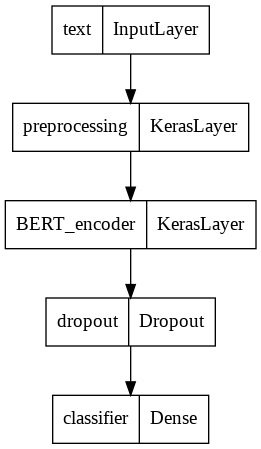

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Treinamento do modelo

### Função de perda (loss)

Por ser um problema para categorizar uma quantidade maior que duas classes, ou seja, por nao ser um problema de resolução binária, foi utilizado a função de perda `losses.CategoricalCrossentropy`.


In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

### Otimizador

Para a etapa de fine-tuning, foi utilizado o mesmo otimizador que o BERT foi  originalmente trainado com: the "Adaptive Moments" (Adam). Esse otimizador minimiza a perda da prediçãoe faz a regularização pelo método de decaimento de peso, também conhecido como [AdamW](https://arxiv.org/abs/1711.05101).

In [ ]:
epochs = 30
steps_per_epoch = len(x_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Carregando o modelo BERT e treinando

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
[print(i.shape, i.dtype) for i in classifier_model.inputs]
[print(o.shape, o.dtype) for o in classifier_model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in classifier_model.layers]

fx_train = np.asarray(x_train).astype(np.str_)
fx_test = np.asarray(x_test).astype(np.str_)
fy_train = np.asarray(y_train).astype(np.float32)
fy_test = np.asarray(y_test).astype(np.float32)

(None,) <dtype: 'string'>
(None, 3) <dtype: 'float32'>
text [(None,)] string
preprocessing None float32
BERT_encoder {'input_word_ids': (None, 128), 'input_mask': (None, 128), 'input_type_ids': (None, 128)} float32
dropout (None, 768) float32
classifier (None, 768) float32


In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 5,
                                                      restore_best_weights = True)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(fx_train, fy_train,
                               epochs=epochs,
                               validation_data=(fx_test, fy_test),
                               callbacks = [earlystop_callback])

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/30
22/22 [==============================] - 25s 296ms/step - loss: 1.1844 - accuracy: 0.1614 - balanced_recall: 0.0000e+00 - balanced_precision: 0.0000e+00 - balanced_f1_score: 0.0000e+00 - val_loss: 1.1551 - val_accuracy: 0.0700 - val_balanced_recall: 0.0000e+00 - val_balanced_precision: 0.0000e+00 - val_balanced_f1_score: 0.0000e+00
Epoch 2/30
22/22 [==============================] - 4s 206ms/step - loss: 1.0949 - accuracy: 0.3343 - balanced_recall: 0.0015 - balanced_precision: 0.0303 - balanced_f1_score: 0.0028 - val_loss: 1.0193 - val_accuracy: 0.6400 - val_balanced_recall: 0.0000e+00 - val_balanced_precision: 0.0000e+00 - val_balanced_f1_score: 0.0000e+00
Epoch 3/30
22/22 [==============================] - 4s 202ms/step - loss: 0.9250 - accuracy: 0.6171 - balanced_recall: 0.0523 - balanced_precision: 0.1935 - balanced_f1_score: 0.0757 - val_loss: 0.8077 - val_accuracy: 0.7300 - val_balanced

### Avaliação do modelo

Performance do modelo

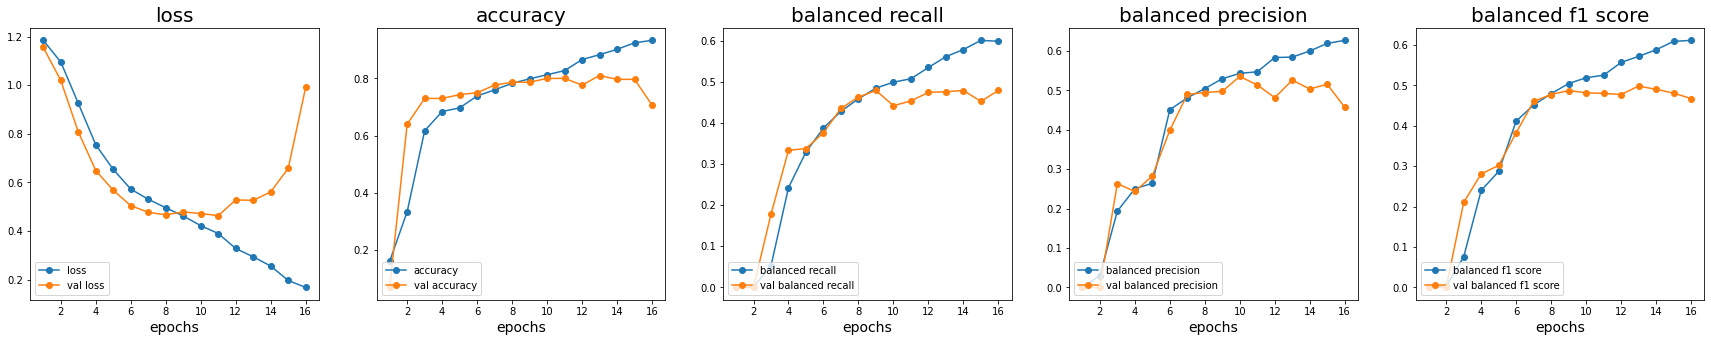

In [ ]:
metric_list = list(history.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  x = list(range(1, len(history.history[metric_list[i]])+1))
  ax[i].plot(x, history.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, history.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
results = dict(zip(classifier_model.metrics_names, classifier_model.evaluate(fx_test, fy_test)))
for criteria, value in results.items():
    print(f'{criteria}: {value}')

10/10 [==============================] - 1s 65ms/step - loss: 0.4632 - accuracy: 0.8000 - balanced_recall: 0.4533 - balanced_precision: 0.5139 - balanced_f1_score: 0.4804
loss: 0.463202565908432
accuracy: 0.800000011920929
balanced_recall: 0.4533030092716217
balanced_precision: 0.5138978362083435
balanced_f1_score: 0.480419397354126


####Matriz de Confusão

10/10 [==============================] - 1s 63ms/step


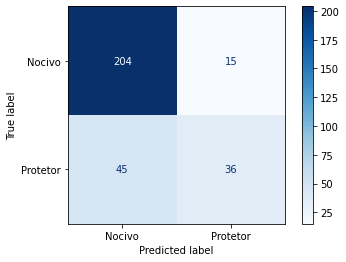

In [ ]:
fy_pred = np.argmax(classifier_model.predict(fx_test), axis=1)
cm = confusion_matrix(np.argmax(fy_test, axis=1), fy_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nocivo', 'Protetor', 'Geral'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

### Gráfico da acurácia e da perda em relação ao tempo

Baseado no objeto `History` retornado pelo `model.fit()`. 

dict_keys(['loss', 'accuracy', 'balanced_recall', 'balanced_precision', 'balanced_f1_score', 'val_loss', 'val_accuracy', 'val_balanced_recall', 'val_balanced_precision', 'val_balanced_f1_score'])


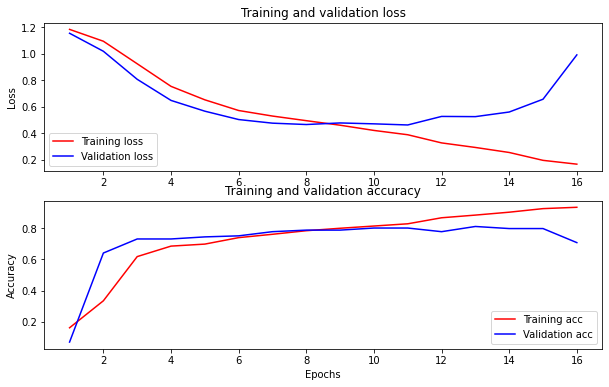

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

As linhas vermelhas representam a perda e acurácia no treinamento e as linhas azuis a perda e acurácia na validação